In [1]:
# packages
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
import yaml, os, logging, sys, glob
pd.set_option("display.max_columns", None)

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# --- logging --- #
import logging
logger = logging.getLogger(__name__)
logger.addHandler(logging.StreamHandler())
logger.setLevel(logging.INFO)

# location of the scripts
sys.path.insert(0, '/fefs/aswg/workspace/juan.jimenez/stereo_analysis/scripts')
import auxiliar as aux
import find_files as find
aux.params() # graphic parameters

dir_irf = '/fefs/aswg/workspace/juan.jimenez/data/dl2/irfs/*'
dir_dl2 = '/fefs/aswg/workspace/juan.jimenez/data/dl2/stereo_raw_dl2_Crab/*'
dir_dl3 = '/fefs/aswg/workspace/juan.jimenez/data/dl3/*'
dir_dl2_lst = '/fefs/aswg/workspace/juan.jimenez/data/dl2/lst/*'

lst_dl2_path = '/fefs/aswg/workspace/abelardo.moralejo/jjimenez_master/Crab_LST1/DL2/dl2_*.h5'

    
# creating a folder to save the plots
pltpath = '/fefs/aswg/workspace/juan.jimenez/stereo_analysis/thesis_plots/plots/'
dpi = 200     # resolution of saved images

In [2]:
files_irf = glob.glob(dir_irf)
files_irf.sort()

logger.info(f'\nThe IRF directory ---> {dir_irf}\nWhere {len(files_irf)} files are found')

files_dl2 = glob.glob(dir_dl2)
files_dl2.sort()

logger.info(f'\nThe DL2 directory ---> {dir_dl2}\nWhere {len(files_dl2)} files are found')

files_dl3 = glob.glob(dir_dl3)
files_dl3.sort()

logger.info(f'\nThe DL3 directory ---> {dir_dl3}\nWhere {len(files_dl3)} files are found')

files_dl2_lst = glob.glob(dir_dl2_lst)
files_dl2_lst.sort()

logger.info(f'\nThe DL2-LST directory ---> {dir_dl2_lst}\nWhere {len(files_dl2_lst)} files are found')

# obs_id_lst = [int(f[-13:-8]) for f in files_dl3 if 'index' not in f]

# # finding dl1 directories for LST
# files_dl1_lst = find.find_LST_dl1(obs_id_lst)

# logger.info(f'\nFor DL1-LST {len(files_dl1_lst)} files are found')


The IRF directory ---> /fefs/aswg/workspace/juan.jimenez/data/dl2/irfs/*
Where 3 files are found

The DL2 directory ---> /fefs/aswg/workspace/juan.jimenez/data/dl2/stereo_raw_dl2_Crab/*
Where 50 files are found

The DL3 directory ---> /fefs/aswg/workspace/juan.jimenez/data/dl3/*
Where 0 files are found

The DL2-LST directory ---> /fefs/aswg/workspace/juan.jimenez/data/dl2/lst/*
Where 1 files are found


In [3]:
# dataframe for all runs
dfs = [pd.read_hdf(file, key='events/parameters') for file in files_dl2]
# run umbers
runs = np.array([int(file[-8:-3]) for file in files_dl2])
# number of events of each run
n_events = np.array([len(df) for df in dfs])

# --- clculating observation time --- #
method = 2

obs_times = []

# mtheod ussing time differences
if method == 1:
    for df in dfs:
        time_diffs = np.diff(df.query(f'tel_id == 1')['timestamp'])
        obs_times.append(time_diffs[time_diffs < 1].sum())

# method using the timestamps and the function "get_effective_time"
elif method == 2:
    from lstchain.reco.utils import get_effective_time

    for df in dfs:
        df['dragon_time'] = df['timestamp']
        df['delta_t']     = df['time_diff']
        obs_times.append(get_effective_time(df.query(f'tel_id == 1'))[0].value)

# converting it to numpy
obs_times = np.array(obs_times)

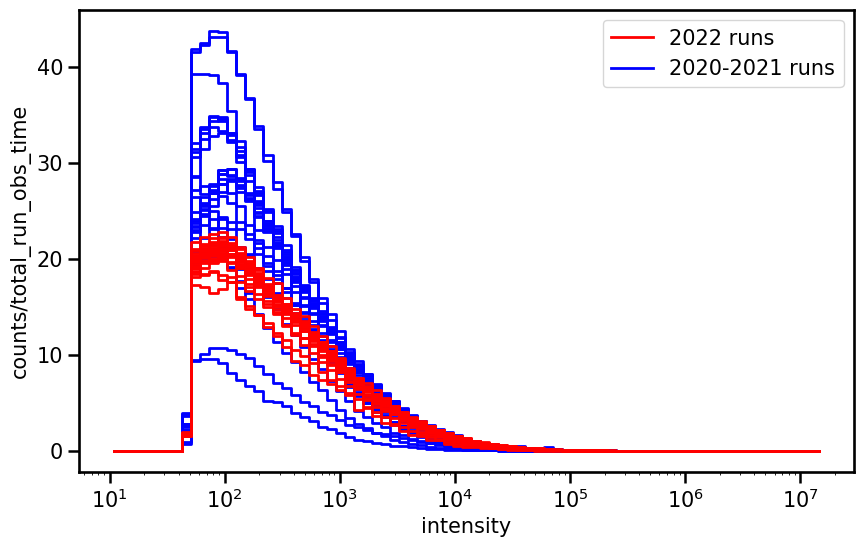

In [4]:
bins = np.logspace(1, 7.2, 80)
bins_c = np.add(bins[:-1], np.diff(bins) / 2)

fig, ax = plt.subplots(figsize=(10,6))

for df, obs_time, run in zip(dfs, obs_times, runs):
    
    
    hist, _ = np.histogram(df['intensity'].to_numpy(), bins=bins) 
        
    hist_norm = hist / obs_time
    
    if run > 7000: 
        ax.plot(bins_c, hist_norm, ds='steps-mid', lw=2, c='r')
    else:
        ax.plot(bins_c, hist_norm, ds='steps-mid', lw=2, c='b')
    
#     print(f'For run {run}: max={max(hist_norm):.1f}')
        
ax.plot([], [], ds='steps-mid', lw=2, c='r', label='2022 runs')
ax.plot([], [], ds='steps-mid', lw=2, c='b', label='2020-2021 runs')
        
ax.legend()
ax.set_xscale('log')
# ax.loglog()
ax.set_xlabel('intensity')
ax.set_ylabel('counts/total_run_obs_time')
plt.show()

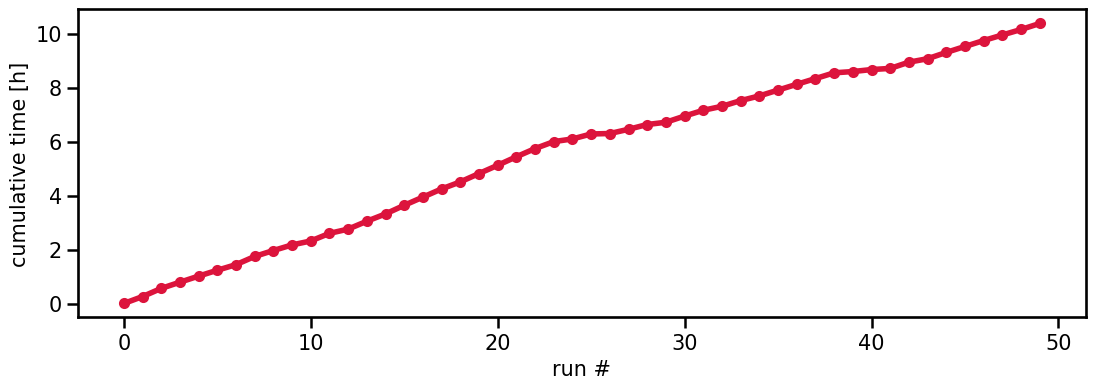

In [5]:
fig, ax = plt.subplots(figsize=(13,4), sharex=True)

ax.plot(np.cumsum(obs_times)/3600,  'o-', color='crimson')

ax.set_ylabel('cumulative time [h]')
ax.set_xlabel('run #')
plt.show()

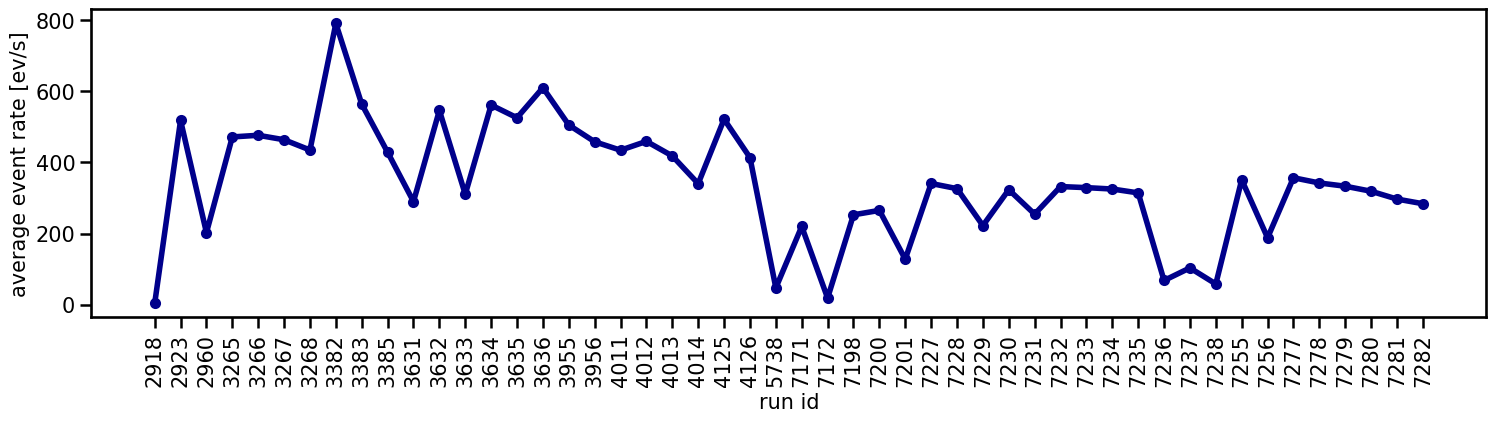

In [6]:
fig, ax = plt.subplots(figsize=(18,4))

ax.plot(runs.astype(str), n_events/obs_time, 'o-', color='darkblue')

ax.xaxis.set_tick_params(rotation=90)
ax.set_xlabel('run id')
ax.set_ylabel('average event rate [ev/s]')
plt.show()

In [7]:
# dataframe for all runs
df_lst  = pd.read_hdf(files_dl2_lst[0], key='events/parameters')
dfs_lst = [df_lst.query(f'obs_id == {run}') for run in runs]

# number of events of each run
n_events_lst = np.array([len(df) for df in dfs_lst])

# --- clculating observation time --- #
obs_times_lst = []

# method using the timestamps and the function "get_effective_time"
from lstchain.reco.utils import get_effective_time

for df in dfs_lst:
    if len(df) > 0:
        obs_times_lst.append(get_effective_time(df)[0].value)
    else:
        obs_times_lst.append(0)
        
# converting it to numpy
obs_times_lst = np.array(obs_times)

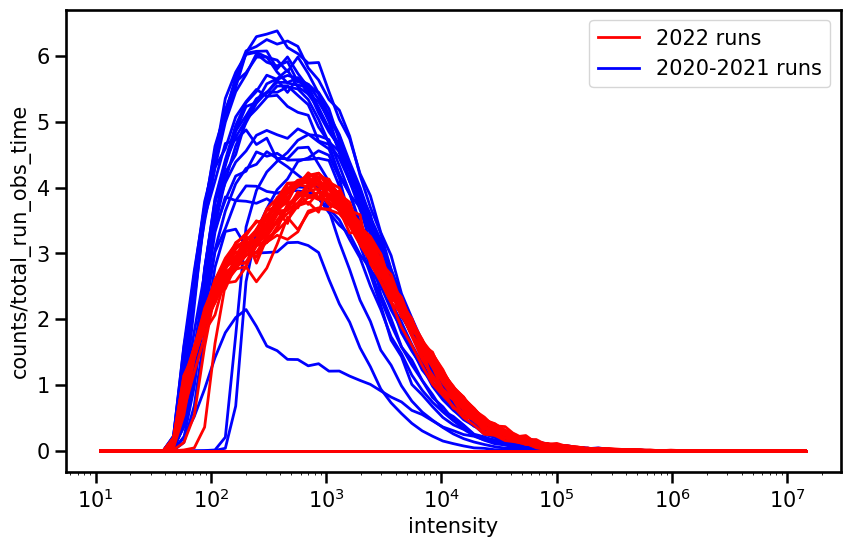

In [8]:
bins = np.logspace(1, 7.2, 70)
bins_c = np.add(bins[:-1], np.diff(bins) / 2)

fig, ax = plt.subplots(figsize=(10,6))

for df, obs_time, run in zip(dfs_lst, obs_times_lst, runs):
    
    
    hist, _ = np.histogram(df['intensity'].to_numpy(), bins=bins) 
        
    hist_norm = hist / obs_time
    
    if run > 7000: 
        ax.plot(bins_c, hist_norm, ds='default', lw=2, c='r')
    else:
        ax.plot(bins_c, hist_norm, ds='default', lw=2, c='b')
    
#     print(f'For run {run}: max={max(hist_norm):.1f}')
        
ax.plot([], [], ds='steps-mid', lw=2, c='r', label='2022 runs')
ax.plot([], [], ds='steps-mid', lw=2, c='b', label='2020-2021 runs')
        
ax.legend()
ax.set_xscale('log')
# ax.loglog()
ax.set_xlabel('intensity')
ax.set_ylabel('counts/total_run_obs_time')
plt.show()

In [9]:
# --- reading dataset --- #
dataset = glob.glob(lst_dl2_path)
dataset.sort()
print(f'Found {len(dataset)} files in {lst_dl2_path}')

tablename = '/dl2/event/telescope/parameters/LST_LSTCam'

# --- column data to extract --- #
columns = ['obs_id', 'event_id', 'intensity', 'dragon_time', 'delta_t', 'event_type']

Found 68 files in /fefs/aswg/workspace/abelardo.moralejo/jjimenez_master/Crab_LST1/DL2/dl2_*.h5


In [10]:
# --- iterating over all files --- #
print(f'\nIterating over all filenames {len(runs)} runs\n')

dfs_dl2_lst_total, obs_times_lst_total, t_elapsed, n_events_lst_total, runs_lst_total = [], [], 0, [], []

for file, i in zip(dataset, range(len(dataset))):

    if int(file[-8:-3]) in runs:
        
        print(f'Reading {file}, ({i/len(dataset)*100:.1f}%)')
        # temporal table with only the requested columns
        tb = pd.read_hdf(file, tablename)[columns]
        tb.query('event_type == 32', inplace=True)
        
        # getting the times of the events
        lt, et = get_effective_time(tb)
        obs_times_lst_total.append(lt.value)
        t_elapsed += et
        n_events_lst_total.append(len(tb))
        runs_lst_total.append(int(file[-8:-3]))

        # appending to main dataframes
        print(f'Events for run {int(file[-8:-3])} are {len(tb)}')
        dfs_dl2_lst_total.append(tb)
        
obs_times_lst_total = np.array(obs_times_lst_total)
n_events_lst_total  = np.array(n_events_lst_total)
runs_lst_total      = np.array(runs_lst_total)

print(f'Completed (100%)')


Iterating over all filenames 50 runs

Reading /fefs/aswg/workspace/abelardo.moralejo/jjimenez_master/Crab_LST1/DL2/dl2_LST-1.Run02923.h5, (0.0%)
Events for run 2923 are 4235176
Reading /fefs/aswg/workspace/abelardo.moralejo/jjimenez_master/Crab_LST1/DL2/dl2_LST-1.Run02960.h5, (2.9%)
Events for run 2960 are 2873535
Reading /fefs/aswg/workspace/abelardo.moralejo/jjimenez_master/Crab_LST1/DL2/dl2_LST-1.Run03265.h5, (5.9%)
Events for run 3265 are 3557312
Reading /fefs/aswg/workspace/abelardo.moralejo/jjimenez_master/Crab_LST1/DL2/dl2_LST-1.Run03266.h5, (7.4%)
Events for run 3266 are 3545590
Reading /fefs/aswg/workspace/abelardo.moralejo/jjimenez_master/Crab_LST1/DL2/dl2_LST-1.Run03267.h5, (8.8%)
Events for run 3267 are 3586709
Reading /fefs/aswg/workspace/abelardo.moralejo/jjimenez_master/Crab_LST1/DL2/dl2_LST-1.Run03268.h5, (10.3%)
Events for run 3268 are 3575904
Reading /fefs/aswg/workspace/abelardo.moralejo/jjimenez_master/Crab_LST1/DL2/dl2_LST-1.Run03382.h5, (11.8%)
Events for run 338

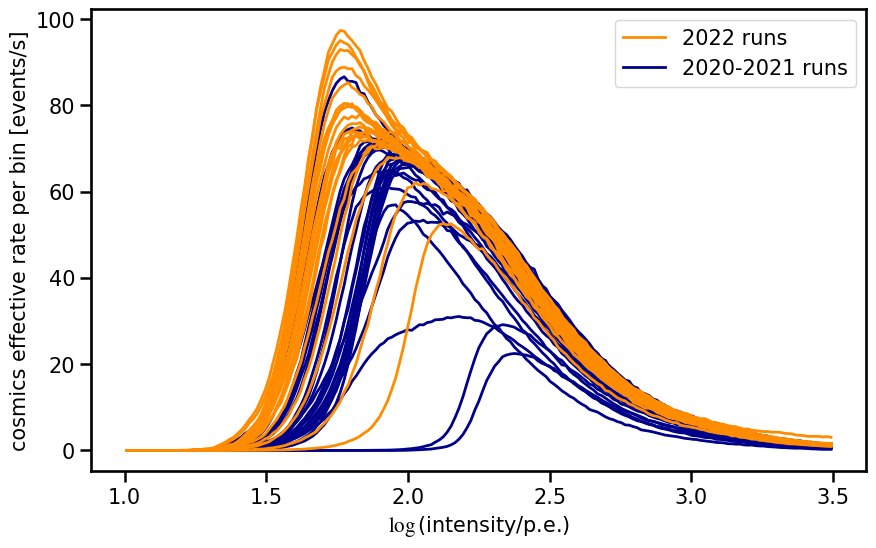

In [11]:
bins = np.linspace(1, 3.5, 180)
bins_c = np.add(bins[:-1], np.diff(bins) / 2)

# run selection index
index_filter = (np.abs(bins_c - 2.1)).argmin()
runs_good, runs_bad = [], []

fig, ax = plt.subplots(figsize=(10,6))

for df, obs_time, run in zip(dfs_dl2_lst_total, obs_times_lst_total, runs):
    
    
    hist, _ = np.histogram(np.log10(df['intensity'].to_numpy()), bins=bins) 
        
    hist_norm = hist / obs_time
    
    if hist_norm[index_filter] >= 62:
        runs_good.append(run)
    else:
        runs_bad.append(run)
    
    if run > 7000: 
        ax.plot(bins_c, hist_norm, ds='default', lw=2, c='darkorange')
    else:
        ax.plot(bins_c, hist_norm, ds='default', lw=2, c='darkblue')
        
ax.plot([], [], ds='steps-mid', lw=2, c='darkorange', label='2022 runs')
ax.plot([], [], ds='steps-mid', lw=2, c='darkblue', label='2020-2021 runs')
        
ax.legend()
ax.set_xlabel('$\log$(intensity/p.e.)')
ax.set_ylabel('cosmics effective rate per bin [events/s]')
plt.show()

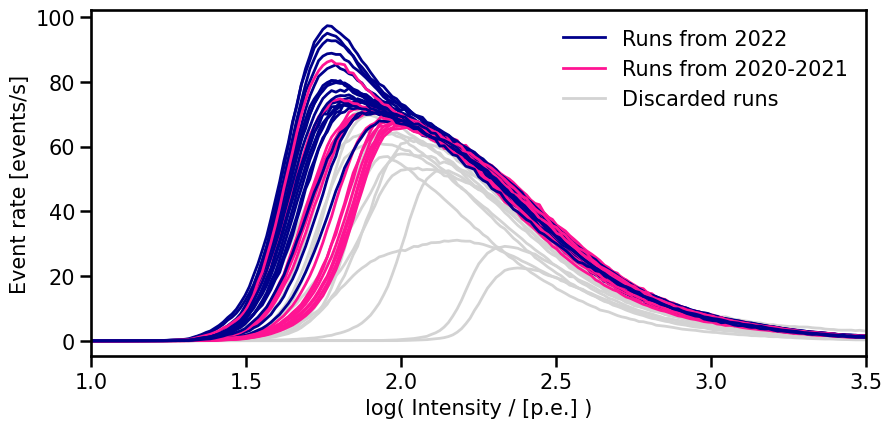

In [12]:
c1 = 'darkblue'
c2 = 'deeppink'
c3 = 'lightgray'

bins = np.linspace(1, 3.5, 180)
bins_c = np.add(bins[:-1], np.diff(bins) / 2)


fig, ax = plt.subplots(figsize=(10,4.5))

for df, obs_time, run in zip(dfs_dl2_lst_total, obs_times_lst_total, runs):
    
    
    hist, _ = np.histogram(np.log10(df['intensity'].to_numpy()), bins=bins) 
        
    hist_norm = hist / obs_time
    
    if run in runs_good and run > 7000: 
        ax.plot(bins_c, hist_norm, ds='default', lw=2, c=c1, zorder=np.random.rand())
    elif run in runs_good and run < 7000:
        ax.plot(bins_c, hist_norm, ds='default', lw=2, c=c2, zorder=np.random.rand())
        
    elif run in runs_bad and run > 7000:
        ax.plot(bins_c, hist_norm, '-', ds='default', lw=2, c=c3, zorder=-1)
    elif run in runs_bad and run < 7000:
        ax.plot(bins_c, hist_norm, '-', ds='default', lw=2, c=c3, zorder=-1)
        
ax.plot([], [], ds='steps-mid', lw=2, c=c1, label='Runs from 2022')
ax.plot([], [], ds='steps-mid', lw=2, c=c2, label='Runs from 2020-2021')
ax.plot([], [], '-', lw=2, c='lightgray', label='Discarded runs')
        
ax.legend(frameon=False)
ax.set_xlabel('log( Intensity / [p.e.] )')
ax.set_ylabel('Event rate [events/s]')
ax.set_xlim(1, 3.5)

plt.savefig(f'{pltpath}intensity-filtering.pdf', bbox_inches='tight', dpi=dpi)
plt.show()

In [13]:
print(f'Selected runs: {runs_good}')
print(f'\nNon-selected runs: {runs_bad}')

Selected runs: [2960, 3265, 3266, 3267, 3268, 3382, 3385, 3631, 3632, 3633, 3634, 3635, 4126, 5738, 7171, 7172, 7198, 7200, 7201, 7227, 7228, 7229, 7230, 7231, 7232, 7233, 7234, 7235, 7236, 7237, 7238, 7255, 7256]

Non-selected runs: [2918, 2923, 3383, 3636, 3955, 3956, 4011, 4012, 4013, 4014, 4125, 7277, 7278]


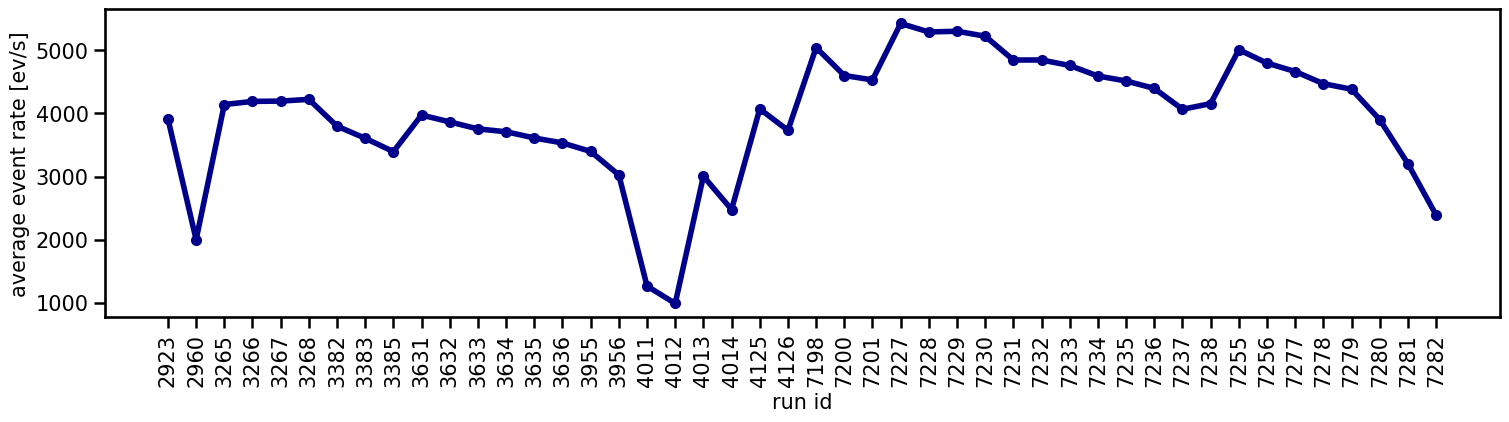

In [14]:
fig, ax = plt.subplots(figsize=(18,4))

ax.plot(runs_lst_total.astype(str), n_events_lst_total/obs_times_lst_total, 'o-', color='darkblue')

ax.xaxis.set_tick_params(rotation=90)
ax.set_xlabel('run id')
ax.set_ylabel('average event rate [ev/s]')
plt.show()